


#         Fichier principal d'exécution du projet                     


***
Auteurs : Gaëtan LE FLOCH, Mehdi FERHAT, Alexis VIGNARD.

In [1]:
import pandas as pd
import SNCFToolbox as ST
import OutilsStatistiques as OST
import Graphes_f as GF
import matplotlib.pyplot as plt
import statsmodels.api as sm # Les seules lignes appelant statsmodels sont facultatives et mises en commentaires.

##         Etape 1 : Analyse et traitement des données

Tout d'abord, nous chargons le dataframe et réalisons les statistiques descriptives : 

In [2]:
dataSNCF = pd.read_csv(".\\regularite-mensuelle-tgv-aqst.csv",sep=";") # Importation des données du CSV
dataSNCF.head()

,Année,Mois,Service,Gare de départ,Gare d'arrivée,Durée moyenne du trajet (min),Nombre de circulations prévues,Nombre de trains annulés,Commentaire (facultatif) annulations,Nombre de trains en retard au départ,...,Retard moyen trains en retard > 15min,Nombre trains en retard > 30min,Nombre trains en retard > 60min,Période,Retard pour causes externes,Retard à cause infrastructure ferroviaire,Retard à cause gestion trafic,Retard à cause matériel roulant,Retard à cause gestion en gare et réutilisation de matériel,Retard à cause prise en compte voyageurs
0,2019,8.0,NaN,PARIS MONTPARNASSE,ANGOULEME,132.545775,289.0,5.0,NaN,172.0,...,37.029412,9.0,3.0,2019-08,31.034483,10.344828,17.241379,24.137931,10.344828,6.896552
1,2019,8.0,NaN,ANGOULEME,PARIS MONTPARNASSE,133.004464,224.0,0.0,NaN,165.0,...,21.208333,1.0,0.0,2019-08,16.666667,25.000000,20.833333,12.500000,8.333333,16.666667
2,2019,8.0,NaN,PARIS MONTPARNASSE,NANTES,132.026030,461.0,0.0,NaN,292.0,...,53.194253,22.0,9.0,2019-08,29.729730,45.945946,10.810811,10.810811,0.000000,2.702703
3,2019,8.0,NaN,PARIS MONTPARNASSE,POITIERS,99.101240,489.0,5.0,NaN,304.0,...,41.350000,9.0,6.0,2019-08,23.529412,19.607843,25.490196,21.568627,3.921569,5.882353
4,2019,8.0,NaN,PARIS MONTPARNASSE,QUIMPER,225.917431,218.0,0.0,NaN,131.0,...,38.000000,6.0,2.0,2019-08,16.666667,41.666667,8.333333,16.666667,0.000000,16.666667


Les colonnes que nous jugeons inutiles sont supprimées et nous créons des indicateurs pour les gares : 

In [3]:
dataSNCF = dataSNCF.drop(["Commentaire (facultatif) annulations","Commentaire (facultatif) retards au départ",
               "Commentaire (facultatif) retards à l'arrivée", "Retard pour causes externes",
                        "Retard à cause infrastructure ferroviaire","Retard à cause gestion trafic",
                        "Retard à cause matériel roulant",
                        "Retard à cause gestion en gare et réutilisation de matériel",  # Retrait de colonnes
                        "Retard à cause prise en compte voyageurs"],axis=1) #  jugées inutiles (doublon ou quasi-vide)

dataSNCF = ST.CreateIndicator(dataSNCF,"Gare de départ",rem=0)
dataSNCF = ST.CreateIndicator(dataSNCF,"Gare d'arrivée") # Les indicatrices sont créées pour les gares.

['AIX EN PROVENCE TGV', 'ANGERS SAINT LAUD', 'ANGOULEME', 'ANNECY', 'ARRAS', 'AVIGNON TGV', 'BARCELONA', 'BELLEGARDE (AIN)', 'BESANCON FRANCHE COMTE TGV', 'BORDEAUX ST JEAN', 'BREST', 'CHAMBERY CHALLES LES EAUX', 'DIJON VILLE', 'DOUAI', 'DUNKERQUE', 'FRANCFORT', 'GENEVE', 'GRENOBLE', 'ITALIE', 'LA ROCHELLE VILLE', 'LAUSANNE', 'LAVAL', 'LE CREUSOT MONTCEAU MONTCHANIN', 'LE MANS', 'LILLE', 'LYON PART DIEU', 'MACON LOCHE', 'MADRID', 'MARNE LA VALLEE', 'MARSEILLE ST CHARLES', 'METZ', 'MONTPELLIER', 'MULHOUSE VILLE', 'NANCY', 'NANTES', 'NICE VILLE', 'NIMES', 'PARIS EST', 'PARIS LYON', 'PARIS MONTPARNASSE', 'PARIS NORD', 'PARIS VAUGIRARD', 'PERPIGNAN', 'POITIERS', 'QUIMPER', 'REIMS', 'RENNES', 'SAINT ETIENNE CHATEAUCREUX', 'ST MALO', 'ST PIERRE DES CORPS', 'STRASBOURG', 'STUTTGART', 'TOULON', 'TOULOUSE MATABIAU', 'TOURCOING', 'TOURS', 'VALENCE ALIXAN TGV', 'VANNES', 'ZURICH']

La fonction CreateIndicator a été exécutée jusqu'au bout.
['AIX EN PROVENCE TGV', 'ANGERS SAINT LAUD', 'ANGOULEME', 

Nous calculons alors le taux de retard :

In [4]:
dataSNCF["NbTrainT"] = dataSNCF["Nombre de circulations prévues"] # Nombre de trains théorique
dataSNCF["NbTrainE"] = dataSNCF["NbTrainT"] - dataSNCF["Nombre de trains annulés"] # Nombre effectif
dataSNCF["NbEnRetard"] = dataSNCF["Nombre de trains en retard à l'arrivée"] # Nombre de retards
dataSNCF["TauxRetard"] = dataSNCF["NbEnRetard"]/dataSNCF["NbTrainE"]

Et nous appliquons une transformée logarithmique pour une variable qui nous servira dans le modèle économétrique :

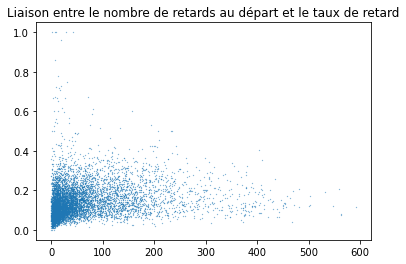

In [5]:
fig = plt.scatter(dataSNCF["Nombre de trains en retard au départ"],
               dataSNCF["TauxRetard"],s=0.05)
plt.title("Liaison entre le nombre de retards au départ et le taux de retard")
plt.show() # Il y a clairement une relation logarithmique à prendre en compte.

dataSNCF = ST.ToLog(dataSNCF,["Nombre de trains en retard au départ"])

##         Visualisation des graphiques (module Graphes_f)

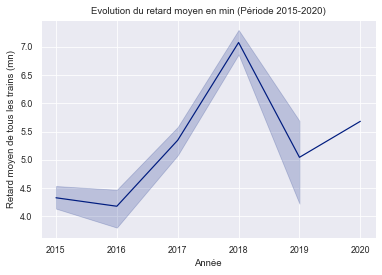

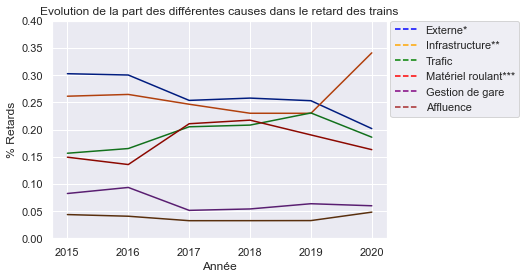

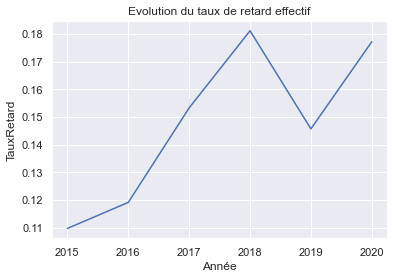

Légendes approfondie des causes : 
 * Présence d'obstacles, intempéries etc. 
 ** Maintenances 
 *** Véhicules ferroviaires obstruant les voies 

Part des retards pour causes externes : 0.26837942939836
Part des retards pour cause d'infrastructure : 0.25123559046540567
Part des retards pour cause de gestion du trafic : 0.19403980434267185
Part des retards pour cause de matériel : 0.18097151146822368
Part des retards pour cause de gestion en gare : 0.06783604026018097
Part des retards pour cause d'affluence voyageurs : 0.03681597507917198
Somme : 0.9992783510140142 



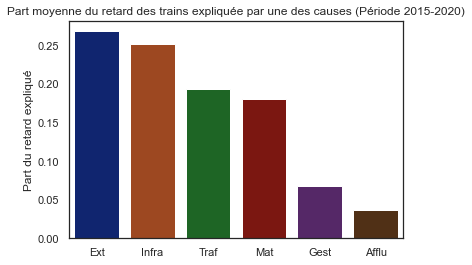

La somme des parts fait effectivement ~ 1, le résidu est négligeable et il est pertinent de faire un diagramme circulaire. 



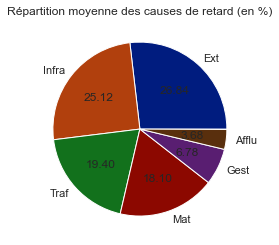

In [6]:
GF.Graphiques()

##         Création du modèle

###                       Choix des variables (visualisation de la Heatmap)

Nous créons une "heatmap" de toutes les variables du dataframe pour visualiser les corrélations : 

Colonnes conservées : 
 ['Année', 'Mois', 'Durée moyenne du trajet (min)', 'Nombre de circulations prévues', 'Nombre de trains annulés', 'Nombre de trains en retard au départ', 'Retard moyen des trains en retard au départ (min)', 'Retard moyen de tous les trains au départ (min)', "Nombre de trains en retard à l'arrivée", "Retard moyen des trains en retard à l'arrivée (min)", "Retard moyen de tous les trains à l'arrivée (min)", '% trains en retard pour causes externes (météo, obstacles, colis suspects, malveillance, mouvements sociaux, etc.)', '% trains en retard à cause infrastructure ferroviaire (maintenance, travaux)', '% trains en retard à cause gestion trafic (circulation sur ligne ferroviaire, interactions réseaux)', '% trains en retard à cause matériel roulant', '% trains en retard à cause gestion en gare et réutilisation de matériel', '% trains en retard à cause prise en compte voyageurs (affluence, gestions PSH, correspondances)', 'Nombre trains en retard > 15min', 'Retard moye

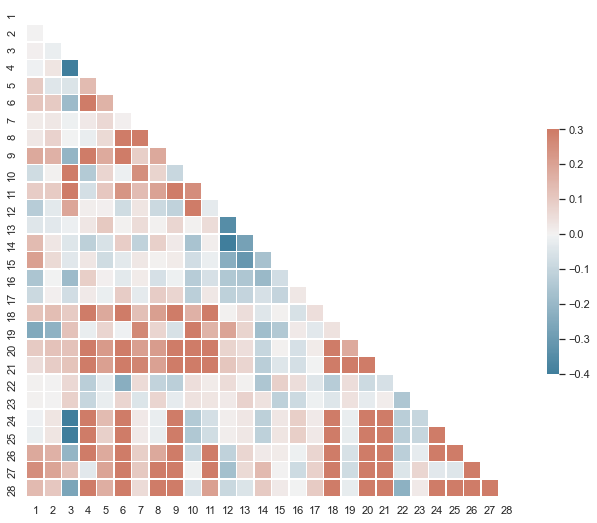

In [7]:
dataHeatMap = dataSNCF.copy().dropna(how="any",axis=0) # Nous dupliquons la base, sans les NA.
OST.HeatMap(dataHeatMap) # Et nous créons une heatmap pour éviter d'intégrer des variables trop corrélées.

Nous exportons la base de données modifiée en format CSV et nous créons une nouvelle base qui ne contient que les variables utiles à l'analyse statistiques (en veillant à ce qu'il n'y ait pas de données manquantes) :

In [8]:
ST.ExportDB(dataSNCF) # Nous exportons cette base de données en .CSV dans notre dossier d'exports.

dataAnalysis = dataSNCF[['TauxRetard',"Durée moyenne du trajet (min)","Nombre de circulations prévues",
                 "ln( Nombre de trains en retard au départ )"]].dropna(how="any",axis=0)

###                      Exécution de la régression

Nous définissons les variables x et y contenant respectivement les explicatives et la variable dépendante :

In [9]:
# Les variables à utiliser

feature_names = ["Durée moyenne du trajet (min)","Nombre de circulations prévues",
                 "ln( Nombre de trains en retard au départ )"] # Explicatives retenues

target_name = 'TauxRetard' # Variable d'intérêt


x = dataAnalysis[feature_names]
y = dataAnalysis[target_name] # Les dataframes contenant les explicatives et la dépendante (respectivement).

Nous utilisons désormais le module OutilsStatistiques et demandons les graphiques des variables ainsi que leurs scatter plots par rapport à la dépendante :

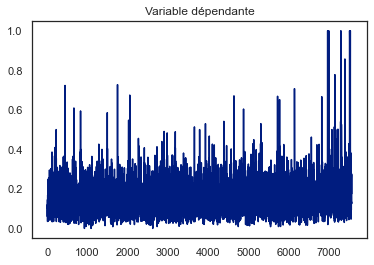

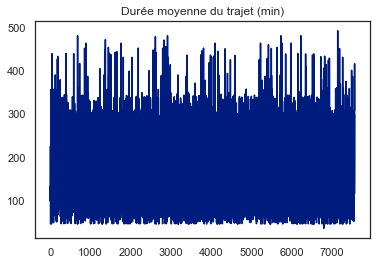

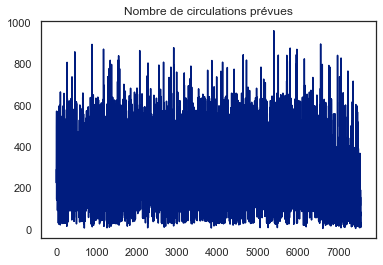

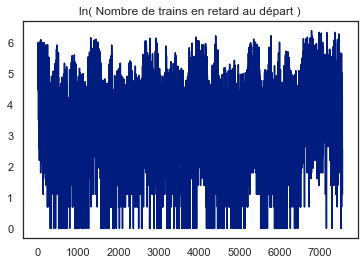

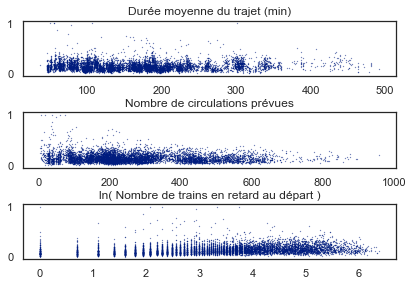

In [10]:
Regression = OST.LROLS(x,y,Label="MCO") # Nous créons notre régression.
Regression.VarGraph() # Les moments d'ordre 1 et 2 n'ont pas toujours l'air constant, il y a des outliers.
Regression.CorrGraph() # Il y a effectivement des outliers, mais nous remarquons des tendances linéaires.

Nous demandons alors les principales statistiques de cette régression : 

[0.08684212962434112, 4.837688506202512e-05, -0.00014531957516381304, 0.02616590789964096]
[22.2049631240047, 3.8501764123762574, -20.350898675123116, 32.96315440120635]
0.13337003040669748
(0.1337175628099564, 0.13337003040669748)


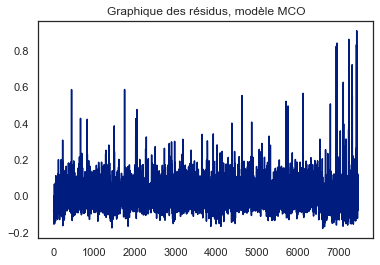

In [11]:
print(Regression.GetCoeffs()) # Coefficients de la régression
print(Regression.GetTStats()) # Tous nos t-stats sont supérieurs à 1.96.
print(Regression.GetR2()) # Les R2 et R2 ajusté.

Regression.PlotResiduals() # Conséquence logique des outliers, le graphique des résidus n'est pas parfait.

D'après le graphique des résidus, il apparaît clairement que le modèle doit être invalidé. Menons quelques tests :

In [12]:
Regression.WhiteS() # Il y aurait hétéroscédasticité d'après le test de White simplifié.
Regression.DurbinWatson() # Il y aurait également autocorrélation des résidus, cf. Durbin-Watson.

La statistique calculée 39.546 est supérieure à la valeur critique 5.99 observée au seuil de 5% et à deux degrés de liberté. Au risque de première espèce de 5%, il y a hétéroscédasticité. 

DW = 1.498, il y a une autocorrélation positive. 



1

Ce modèle possède des résidus hétéroscédastiques et autocorrélés, il faudra pousser l'analyse plus loin. En attendant, nous stockons les résultats de la régression dans un fichier texte :

In [13]:
Regression.ExportResults() # Nous exportons les résultats de cette régression dans un fichier texte.

0.13337003040669748
0.13337003040669748
La statistique calculée 39.546 est supérieure à la valeur critique 5.99 observée au seuil de 5% et à deux degrés de liberté. Au risque de première espèce de 5%, il y a hétéroscédasticité. 

DW = 1.498, il y a une autocorrélation positive. 

Le fichier a été créé / mis à jour.


###                     Facultatif

Tous nos calculs peuvent être retrouvés à l'aide de la librairie statsmodels :

                            OLS Regression Results                            
Dep. Variable:             TauxRetard   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     384.8
Date:                Sun, 22 Nov 2020   Prob (F-statistic):          2.05e-232
Time:                        17:49:27   Log-Likelihood:                 8384.1
No. Observations:                7482   AIC:                        -1.676e+04
Df Residuals:                    7478   BIC:                        -1.673e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

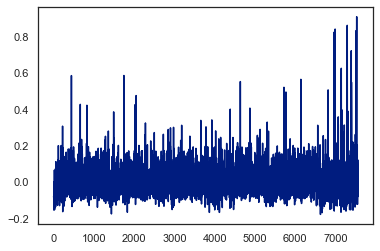

In [14]:
# -- Si vous voulez vérifier les calculs, lancez les lignes ci-dessous avec statsmodels --

X2 = sm.add_constant(x)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())
residuals = est2.resid
fig = plt.plot(residuals)